<h1><center> <font color='black'> Business Data Analytics - Practice Session_11 </font></center></h1>
<h2><center> <font color='black'> Fraud detection</font></center></h3>
<h2><center> <font color='black'> University of Tartu - Spring 2020</font></center></h3>

# Introduction

<h3 ><center>"The need for fraud
    prevention services has never been greater."</center></h3>


Among top 10 types of frauds today are: 
    
- **Wire fraud**: Using electronic and traditional communication means to obtain money based on false promises.

- **Card fraud**: Using someone's else credit card or credit account to make an unauthorized purchase.

- **Mortage fraud**: Providing false information that leads to a mortgage loan approval.

- **Insurance fraud**: Someone knowingly lies to obtain a benefit or advantage to which they are not otherwise entitled.





>The total value of fraudulent transactions annually
amounting to **€1.8 Billion**. (European Central Bank)
>
>Technology advancments are serving as a tool for fraudlasters with some scams and frauds offered as  Fraud as a Service (Faas) online.


The industries affected by fraud vary from financial institutions, travel companies, online gaming, insurance etc. They apply preventive and detective solutions. Fraud detection solutions fall into 5 main categories:

- **Expert-based rule engine**
- **Descriptive analytics (unsupervised learning)**
- **Predictive analytics (Supervised learning techniques)**
- **Cluster Migration Analysis**
- **Social network analysis**

On this lab we will focus on detecting **Credit card fraud** using **Predictive analytics** tools.

In general the workflow of financial fraud detection is as shown in the figure. There is a constant need to build, evaluate and re-train models. Other techniques like **online machine learning** can be used as well.

In [1]:
from IPython.display import display, Image


In [2]:

display(Image(url= "https://miro.medium.com/max/1400/1*B452Vt6o-vCkzFbAewPubg.jpeg",unconfined=True))

**You can read an interesting Europaean fraud report(2019) by nets.eu in this [link](https://www.nets.eu/solutions/fraud-and-dispute-services/Documents/Nets-Fraud-Report-2019.pdf)

# Credit fraud detection using classification

## 1. Dataset exploration
https://www.kaggle.com/mlg-ulb/creditcardfraud

#### Description
The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [3]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

In [4]:
df = pd.read_csv('creditcard.csv')

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
# Remove any infinity or NaN values
print('df length before removing nan/inf: ', len(df))
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
print('df length after removing nan/inf: ', len(df))

df length before removing nan/inf:  284807
df length after removing nan/inf:  284807


In [7]:
print('Not Fraud:', round(df['Class'].value_counts()[0]/len(df) * 100, 2), '% of the dataset')
print('Fraud:', round(df['Class'].value_counts()[1]/len(df) * 100, 2), '% of the dataset')

Not Fraud: 99.83 % of the dataset
Fraud: 0.17 % of the dataset


### Distribution of Amount and Time

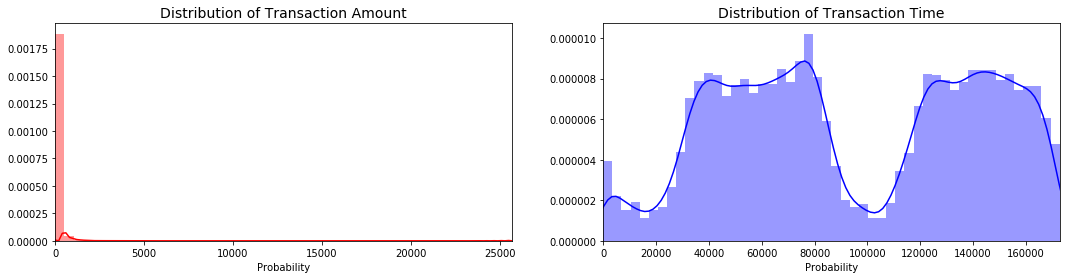

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])
ax[0].set_xlabel('Amount (Euro)')
ax[0].set_xlabel('Probability')

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])
ax[1].set_xlabel('Time (s)')
ax[1].set_xlabel('Probability')


plt.show()

### Correlation

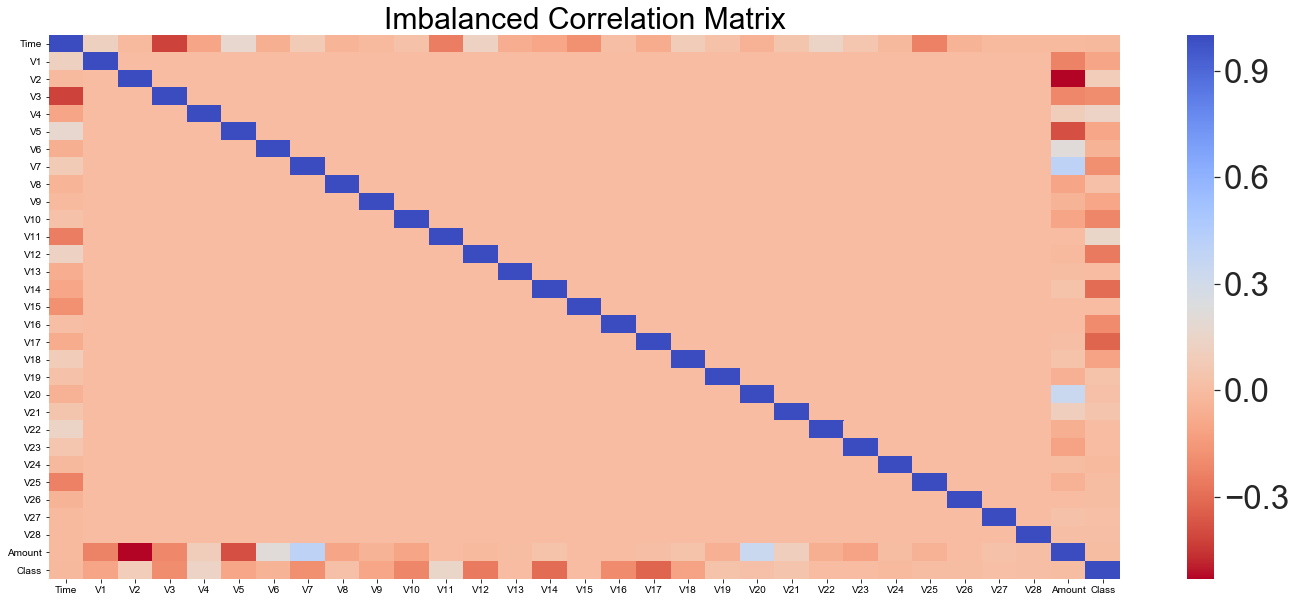

In [9]:
fig, ax = plt.subplots(figsize=(24,10))
sns.set(font_scale=3)

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':30}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix", fontsize=30)
plt.show()

## 2. Data preprocessing

### Feature scaling

In [10]:
# Scale features 'amount' and 'time' to match scale of other features in dataset
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [11]:
# This cell simply moves the scaled_amount and scaled_time to be the first 2 columns
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!
df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


### Subsampling to avoid:
* Overfitting
* Wrong correlation

In [12]:
# Lets shuffle the data before creating the subsamples
df = df.sample(frac=1, random_state=888)
df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
123630,0.796479,-0.090332,1.376739,-1.396695,0.263759,-1.379968,-1.340104,0.098635,-1.117348,0.063504,...,-0.210581,-0.416354,-0.863712,-0.056810,-0.538201,0.368794,-0.302822,0.025950,0.014627,0
241317,3.414937,0.778722,1.266056,-0.511505,-1.186329,3.700333,0.882664,1.777500,0.253790,0.446246,...,0.067181,0.025308,-0.447666,0.120726,-1.502572,-0.502759,-0.187192,-0.047011,-0.028710,0
229695,0.269545,0.720474,-0.465172,0.710381,0.533386,-0.826619,1.128684,-0.450094,1.200589,-0.197607,...,0.123717,-0.187828,-0.600680,0.008571,0.504982,-0.174511,0.151821,0.044091,0.146674,0
51190,0.013973,-0.468274,-0.714825,0.980626,1.415552,0.069496,0.759452,-0.881875,1.421885,-0.344199,...,-0.226502,-0.223342,-0.616842,-0.019527,0.329693,-0.226131,-0.884865,-0.191276,-0.090938,0
3630,-0.023335,-0.958505,1.235561,-0.355878,-0.430046,-0.500626,1.468465,3.712712,-1.148487,1.006038,...,0.074590,0.028588,-0.059221,-0.023264,1.033991,0.345452,0.364364,0.008946,0.025318,0


In [13]:


# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:len(fraud_df)]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

In [14]:
print('Not Fraud:', round(new_df['Class'].value_counts()[0]/len(new_df) * 100, 2), '% of the dataset')
print('Fraud:', round(new_df['Class'].value_counts()[1]/len(new_df) * 100, 2), '% of the dataset')

Not Fraud: 50.0 % of the dataset
Fraud: 50.0 % of the dataset


In [15]:
new_df.shape

(984, 31)

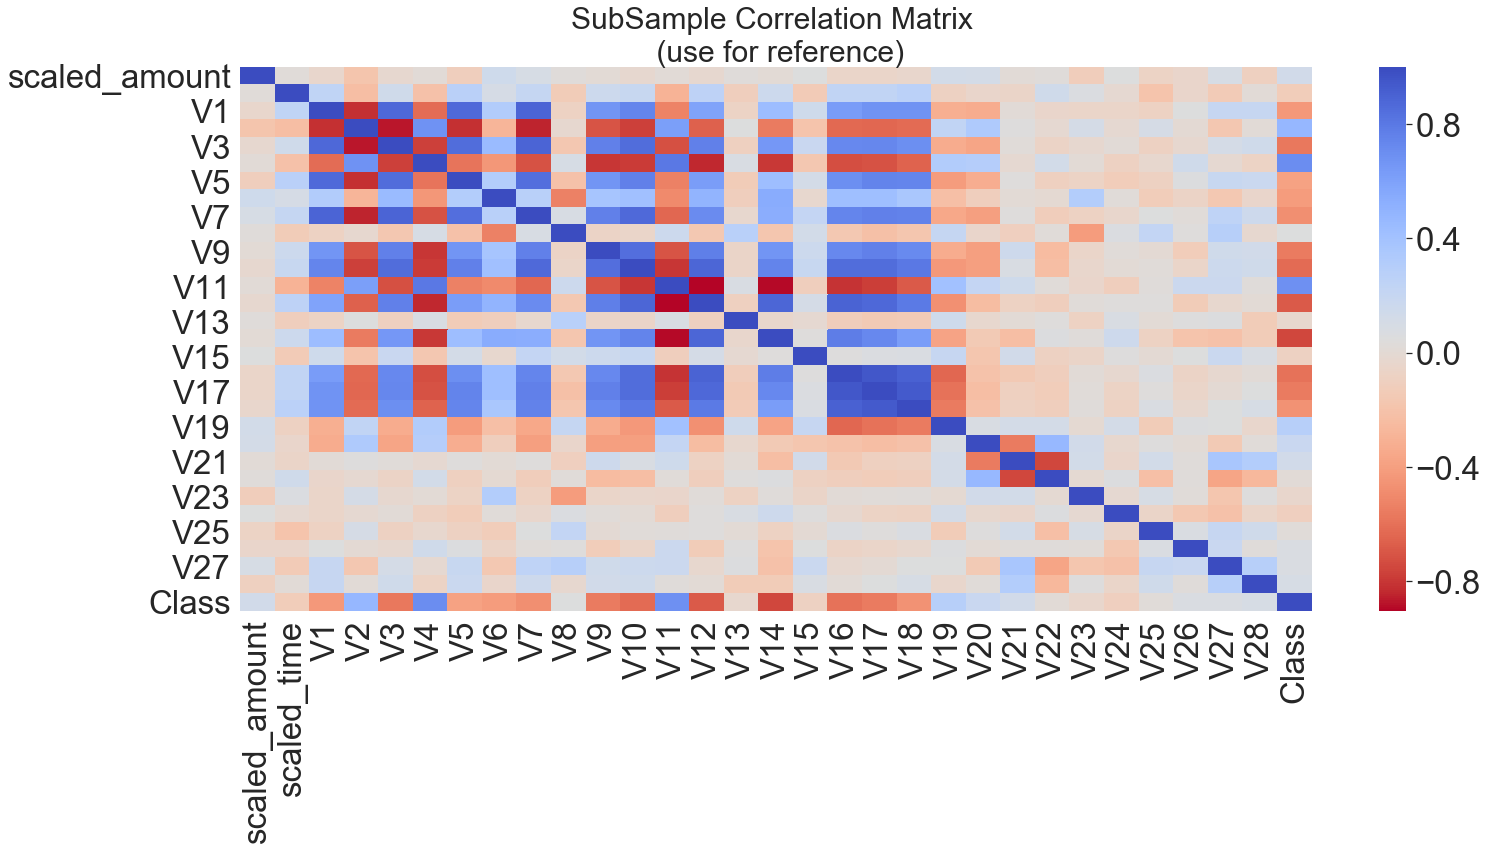

In [16]:
# Make sure we use the subsample in our correlation

f, ax = plt.subplots( figsize=(24,10))

sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax)
ax.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=30)
plt.show()

### Principal component analysis

In [17]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42, svd_solver='full').fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

PCA took 0.077 s


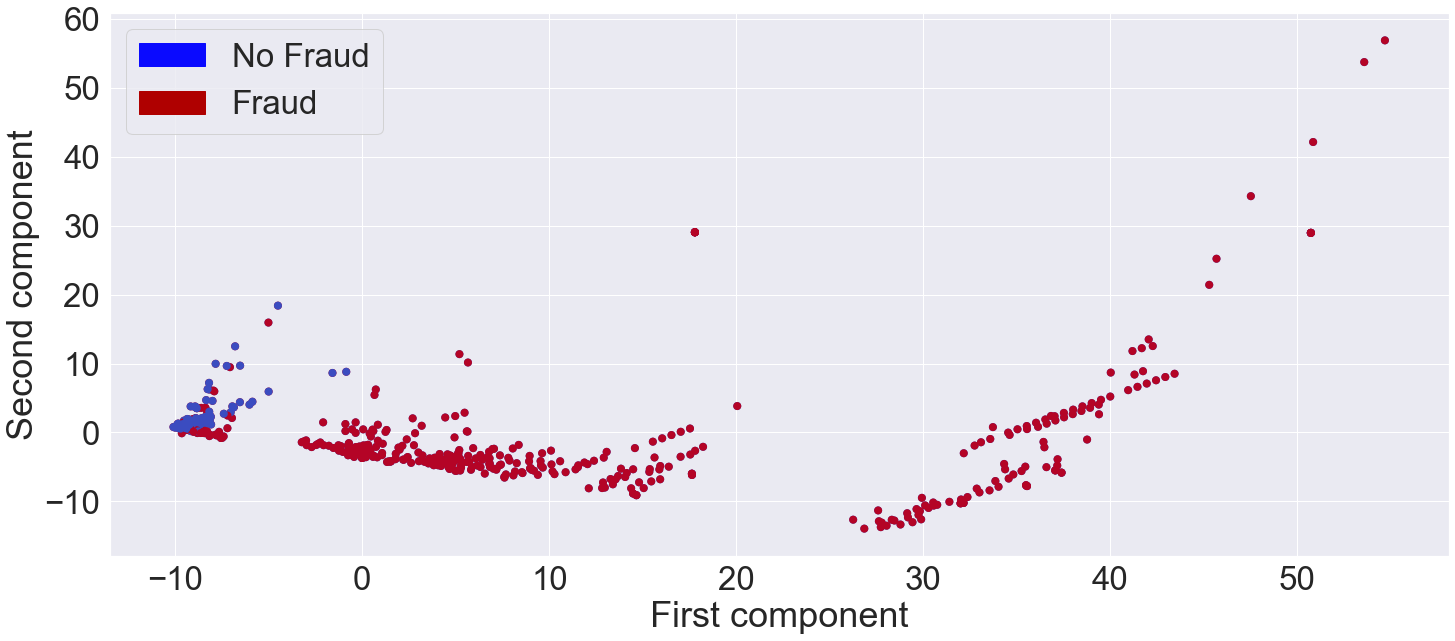

In [18]:
# PCA scatter plot
#f, (ax1) = plt.subplots(1, 1, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']\
plt.rcParams["figure.figsize"] = (24,10)
blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

plt.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
plt.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)

plt.grid(True)
plt.legend(handles=[blue_patch, red_patch])
plt.xlabel('First component')
plt.ylabel('Second component')

plt.show()

## 3. Using classification for fraud detection

There are several algorithms used to detect fraud  among them genetic algorithms, neural networks, random forest etc. In today's practice session we are going to use Software Vector Machine algorithm.

In [19]:
# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.svm import SVC
import warnings

warnings.filterwarnings("ignore")

svc = SVC()

svc.fit(X_train, y_train)
training_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Training score: ', round(training_score.mean(), 2)*100, "% accuracy score")

Training score:  93.0 % accuracy score


### Hyperparameter tuning

During the practice sessions until now, for our machine learning models, we have used default parameters or some predefined values. In practical applications, the job of a data scientist includes actually trying different hyperparameter combinations and evaluating which one of them gives the best results. This process is called hyperparameter optimization or hyperparameter tuning. This is a crucial step ass the performance of most of the algorithms is highly dependent on the hyperparameter choice. The process usually includes two strategies: 

- **Exploitation**
- **Exploration**

In python, the scikit-learn module offers two functions which automates the hyperparameter search process: GridSearchCV and RandomizedSearchCV

In [21]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_
print(grid_svc.best_params_)

{'C': 0.7, 'kernel': 'poly'}


In [22]:
updated_training_score = cross_val_score(svc, X_train, y_train, cv=5,)
print('Training score: ', round(updated_training_score.mean(), 2)*100, "% accuracy score")

Training score:  94.0 % accuracy score


### Model evaluation

In [23]:
## By default the score property calculates accuracy score
acc = svc.score(X_test, y_test)
print('Accuracy score in test data', acc)

Accuracy score in test data 0.9441624365482234


In [24]:
svc_pred = svc.predict(X_test)

In [25]:
from sklearn.metrics import classification_report
                                                  
print(classification_report(y_test, svc_pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94        87
           1       0.98      0.92      0.95       110

    accuracy                           0.94       197
   macro avg       0.94      0.95      0.94       197
weighted avg       0.95      0.94      0.94       197



In [26]:
from sklearn.metrics import roc_auc_score, roc_curve

print('Support Vector Classifier: ', roc_auc_score(y_test, svc_pred))

Support Vector Classifier:  0.9475966562173459


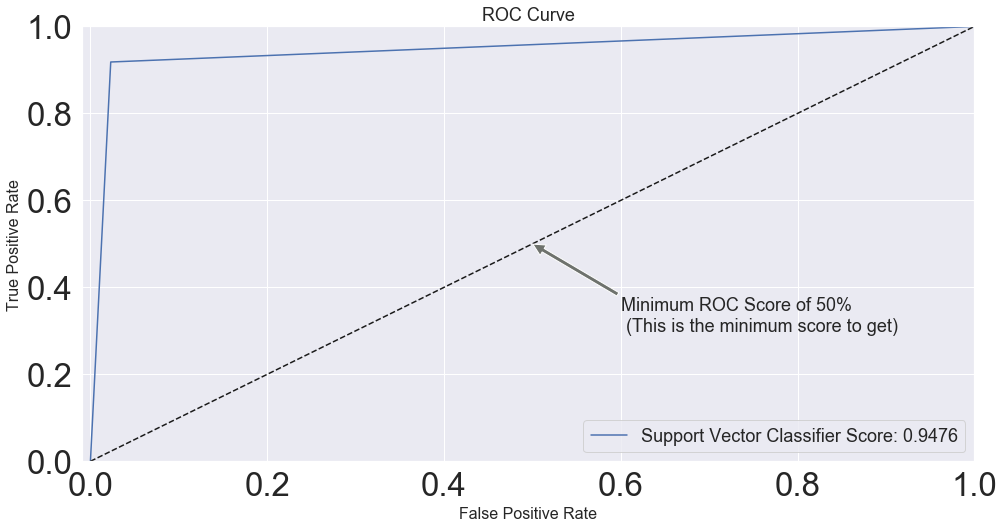

In [28]:
# Plot the ROC curve
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_test, svc_pred)

plt.figure(figsize=(16,8))
plt.rcParams.update({'font.size': 18})

plt.title('ROC Curve', fontsize=18)
plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_test, svc_pred)))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
            arrowprops=dict(facecolor='#6E726D', shrink=0.005),
            )
plt.legend(prop={'size': 18})
plt.show()

### References
* https://www.kaggle.com/mlg-ulb/creditcardfraud
* https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets
* https://imbalanced-learn.readthedocs.io/en/stable/api.html
* https://scikit-learn.org/stable/user_guide.html